In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import utils

In [2]:
IMG_SIZE = 180

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

image.shape = (333, 500, 3)


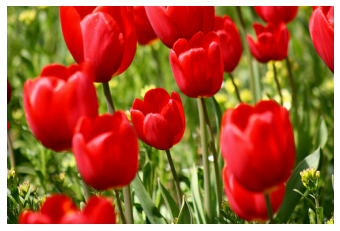

In [4]:
image, label = next(iter(train_ds))
print(f"image.shape = {image.shape}")
utils.plot_image(image)

## Resizing and rescaling

In [5]:
resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

np.min(preprocessed) = 0.0, np.max(preprocessed) = 1.0
preprocessed.shape = (180, 180, 3)


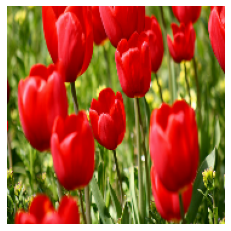

In [6]:
preprocessed = resize_and_rescale(image)
print(f"np.min(preprocessed) = {np.min(preprocessed)}, np.max(preprocessed) = {np.max(preprocessed)}")
print(f"preprocessed.shape = {preprocessed.shape}")

utils.plot_image(preprocessed)

## Data augmentation

In [7]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
preprocessed = tf.expand_dims(preprocessed, 0)
print(f"preprocessed.shape = {preprocessed.shape}")

preprocessed.shape = (1, 180, 180, 3)


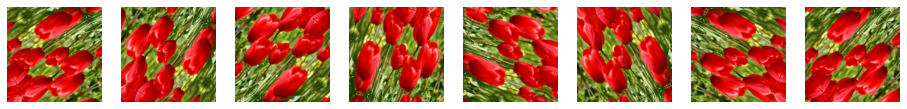

In [9]:
augmented_images = []
for _ in range(8):
    augmented = data_augmentation(preprocessed)
    augmented_images.append(augmented)

utils.plot_images(augmented_images)

## Use in model

In [10]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Rest of your model
])

## Use in dataset

In [11]:
aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

In [12]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)